# Week 2 Mini project
## Predicting copper future price 

### 1. Background

A copper future is a legally binding agreement to buy or sell a standard quantity of Grade-A cathode copper at a preset price for delivery (or cash‐settlement) on a future date. Producers hedge price risk, manufacturers lock-in costs, and speculators trade anticipated moves.

There are three major future exchanges that trade copper contracts, namely, Shanghai Futures Exchange (CU), London metal exchange (CA), and CME Group / COMEX Copper (HG). Copper contracts in the three exchanges often share similar prices but are almost never identical. This is because the three markets operate in different time, and are technically selling copper contrasts in different countries. A brief summary of the differences across the three exchanges can be found at the end of this document. 

In this project, we will try to leverage the three exchange markets as well as the abudant data on the Internet to build a predictive model for U.S. copper contract prices. 

> In a recent announcement, a $50\%$ tariff will be imposed on imported copper to U.S., which should drive up the U.S. copper contract price. However, according to [a news piece](https://www.reuters.com/markets/commodities/trumps-copper-tariffs-wont-lift-us-output-will-boost-costs-2025-07-10/) by Reuters: "U.S. copper contracts rose to a 26% premium over their London equivalent on Wednesday from a 13% premium before Trump's announcement. That 26% premium is still well short of the 50% tariff, likely indicating the uncertainty in the market as to what types of copper products will be subject to tariffs or the risk of a lower rate for some countries." 

### 2. Objective

The grand objective is simple: to build a model to predict the U.S. copper contracts price per day. You are free to fit any models or use any data you can find, as long as the model uses only data before the market opens on the day of interest (i.e., no data leakage). 

To get started, you can run the following cells to download the copper contract prices from the three exchanges. You might need to install some libraries if you see errors complaining on libraries found. 


In [1]:
# !pip install yfinance  # uncomment once if you don't have yfinance yet
import yfinance as yf
import pandas as pd

# ------------------------------------------------------------
# 1.  Download daily front-month copper futures (COMEX)
# ------------------------------------------------------------
ticker = "HG=F"                # Copper continuous contract on Yahoo Finance
start  = "2010-01-01"          # any start date you like
end    = "2025-07-15"          # or leave end=None for “today”

NY = yf.download(ticker, start=start, end=end, interval="1d")

# Quick sanity-check
print(NY.head())
print(NY.tail())


/var/folders/7k/pmrkdmm532g7zc20cgygtd4w0000gn/T/ipykernel_92963/2572483441.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  NY = yf.download(ticker, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 completed

Price        Close    High     Low    Open Volume
Ticker        HG=F    HG=F    HG=F    HG=F   HG=F
Date                                             
2010-01-04  3.3880  3.4090  3.3530  3.3880    404
2010-01-05  3.3960  3.4110  3.3685  3.3960    242
2010-01-06  3.4775  3.4995  3.4335  3.4775    109
2010-01-07  3.4115  3.5235  3.4110  3.4995    326
2010-01-08  3.3880  3.4220  3.3800  3.3880    311
Price        Close   High     Low   Open Volume
Ticker        HG=F   HG=F    HG=F   HG=F   HG=F
Date                                           
2025-07-08  5.6450  5.645  4.9495  4.968    922
2025-07-09  5.4435  5.682  5.3975  5.467    857
2025-07-10  5.5480  5.593  5.5435  5.580    756
2025-07-11  5.5620  5.585  5.4500  5.585   1082
2025-07-14  5.5150  5.515  5.4495  5.476   1082


In [ ]:
# pip install akshare
# pip install pandas_datareader 

import akshare as ak
import datetime as dt
from pandas_datareader import data as web

MT_TO_LB = 2204.62262    
# main (dominant) copper contract from Sina Finance, date index ascending
SHFE = ak.futures_main_sina(symbol="CU0",end_date="20250715",start_date="20150101")   # "CU0" -> SHFE copper continuous
# rename to English
SHFE = SHFE.rename(columns={
    "日期": "date",
    "开盘价": "open",
    "最高价": "high",
    "最低价": "low",
    "收盘价": "close",
    "成交量": "volume",
    "持仓量": "open_interest",
    "动态结算价": "settlement_price"
})
# ---- FX: CNY per USD (daily) --------------------------------
fx = (
    web.DataReader(
        "DEXCHUS",      # Yuan per 1 USD (FRED)
        "fred",
        2005,
        2025  # or leave end=None for “today”
    )
    .rename(columns={"DEXCHUS": "cny_per_usd"})
    .ffill()                        # forward-fill weekends / holidays
)

# ---- merge & convert ----------------------------------------
SHFE.set_index("date", inplace=True)        # make 'date' the index
SHFE.sort_index(inplace=True)               # (optional) keep rows in chrono order

SHFE = SHFE.join(fx, how="left")
SHFE["usd_per_ton"] = SHFE["close"] / SHFE["cny_per_usd"]
SHFE["usd_per_lb"]  = SHFE["usd_per_ton"] / MT_TO_LB

print(SHFE.head())


             open   high    low  close  volume  open_interest  \
date                                                            
2015-01-05  45500  45570  44990  45080  189194         325160   
2015-01-06  44210  44910  43980  44800  447986         310542   
2015-01-07  44640  44840  44420  44650  317816         301058   
2015-01-08  44650  44890  44580  44680  208524         297932   
2015-01-09  45000  45050  44250  44250  384066         308602   

            settlement_price  cny_per_usd  usd_per_ton  usd_per_lb  
date                                                                
2015-01-05             45250       6.2201  7247.471906    3.287398  
2015-01-06             44570       6.2125  7211.267606    3.270976  
2015-01-07             44660       6.2127  7186.891368    3.259919  
2015-01-08             44740       6.2143  7189.868529    3.261270  
2015-01-09             44550       6.2085  7127.325441    3.232900  


In [7]:
# The LME copper price is available MONTHLY from the IMF database
start = dt.datetime(1990, 1, 1)
LME= web.DataReader("PCOPPUSDM", "fred", start)   # IMF / LME cash price

LME.rename(columns={"PCOPPUSDM": "usd_per_ton"}, inplace=True)
LME["usd_per_lb"] = LME["usd_per_ton"] / MT_TO_LB

print(LME.head())

            usd_per_ton  usd_per_lb
DATE                               
1990-01-01  2365.556991    1.072999
1990-02-01  2358.943400    1.069999
1990-03-01  2625.702723    1.190999
1990-04-01  2685.226891    1.217998
1990-05-01  2740.342391    1.242998


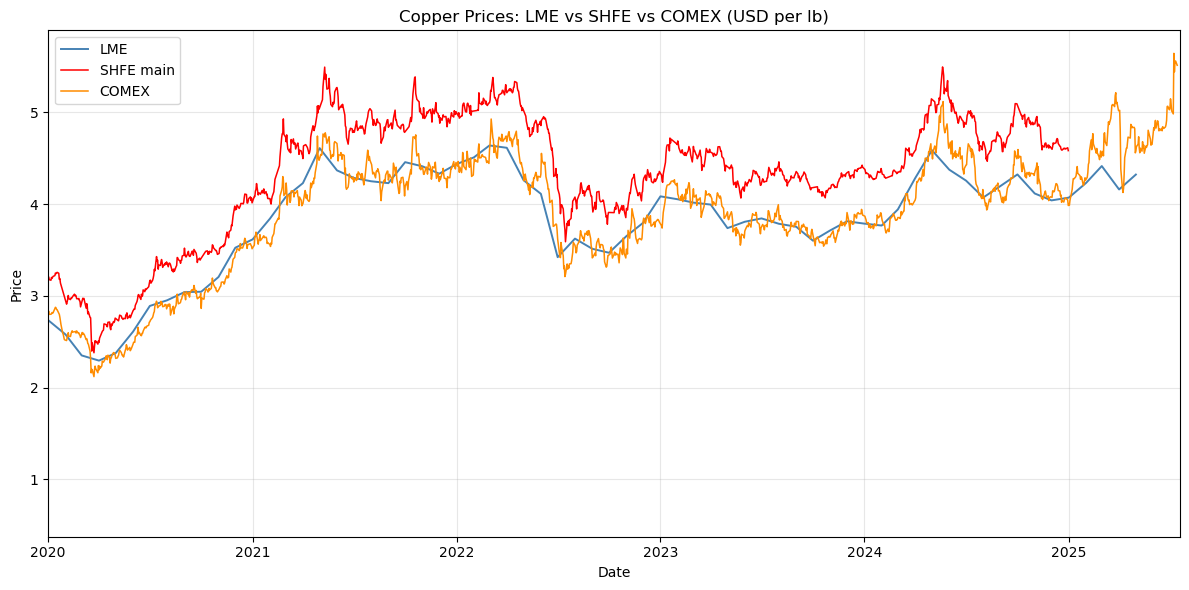

In [8]:

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.plot(LME.index, LME["usd_per_lb"],
         label="LME", linewidth=1.4, color="steelblue")

plt.plot(SHFE.index, SHFE["usd_per_lb"],
         label="SHFE main", linewidth=1.1, color="red")
plt.plot(NY.index, NY["Close"],
         label="COMEX", linewidth=1.1, color="darkorange")

plt.title("Copper Prices: LME vs SHFE vs COMEX (USD per lb)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
start_xlim = pd.Timestamp("2020-01-01")
end_xlim   = pd.Timestamp("2025-07-19")
plt.xlim(start_xlim, end_xlim)  
plt.show()

## Appendix: Summary of the three exchanges

| Exchange (venue code)                       | Contract unit        | Price quote   | Typical trading hours (local)         | Warehouse/delivery system                                   | Tick size                                                      |
| ------------------------------------------- | -------------------- | ------------- | ------------------------------------- | ----------------------------------------------------------- | -------------------------------------------------------------- |
| **London Metal Exchange – LME Copper (CA)** | 25 metric tonnes     | USD per tonne | 01:00-19:00 London (ring + LMEselect) | Global LME-approved sheds; *“warrants”* transferable        | USD 0.10/tonne ([Lme][1])                                      |
| **Shanghai Futures Exchange – SHFE 铜 (CU)** | 5 t                  | CNY per ton   | 09:00-15:00 & 21:00-02:00 Beijing     | Mainland China warehouses; VAT & import‐quota rules apply   | ¥10/ton (≈USD 1.4) ([tsite.shfe.com.cn][2], [Barchart.com][3]) |
| **CME Group / COMEX Copper (HG)**           | 25 000 lb (≈11.34 t) | USD ¢ per lb  | 18:00-17:00 ET (electronically)       | U.S. COMEX-licensed warehouses; deliverable Grade 1 cathode | USD 0.0005/lb ([CME Group][4], [CME Group][5])                 |

[1]: https://www.lme.com/en/metals/non-ferrous/lme-copper/contract-specifications?utm_source=chatgpt.com "Contract specifications | London Metal Exchange"
[2]: https://tsite.shfe.com.cn/eng/market/futures/metal/cu/index.html?utm_source=chatgpt.com "Copper"
[3]: https://www.barchart.com/futures/quotes/VC%2A0/profile?utm_source=chatgpt.com "SHFE Copper Aug '25 Futures Contract Specifications - Barchart.com"
[4]: https://www.cmegroup.com/markets/metals/base/copper.contractSpecs.html?utm_source=chatgpt.com "Copper Futures Contract Specs - CME Group"
[5]: https://www.cmegroup.com/markets/metals/base/copper.html?utm_source=chatgpt.com "Copper Futures Overview - CME Group"
